In [1]:
import pandas as pd
import numpy as np
import math
import time
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid')

from fbprophet import Prophet

from sklearn.metrics import mean_absolute_error

np.random.seed(123)

In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true))

# Generating data

In [3]:
def f_1(time):
    """
    time: np.array (len_ts,)
    """
    return time.reshape(-1,1)

def f_2(time):
    noise = np.random.randn(time.shape[0])
    f = lambda t: t * np.sin(t) + 200
    vfunc = np.vectorize(f)
    f_time = vfunc(time)
    return (f_time+noise).reshape(-1,1)

def f_3(time, period):
    f = lambda t: 100 * np.sin(t // period) + 100 + 2*t
    vfunc = np.vectorize(f)
    f_time = vfunc(time)
    return f_time.reshape(-1,1)

def f_4(time, period):
    f = lambda t: 100 * np.cos(t // period) + 100 + 2*t
    vfunc = np.vectorize(f)
    f_time = vfunc(time)
    return f_time.reshape(-1,1)

def generate_ts_1(exog):
    """
    exog: np.array (len_ts, k_exog)
    """
    a = (np.ones(exog.shape[1])/exog.shape[1]).reshape(-1,1)
    y = exog @ a
    return y

def generate_ts_2(exog):
    y = np.zeros(exog.shape[0])
    a = (np.ones(exog.shape[1])/exog.shape[1]).reshape(-1,1)
    for i in range(exog.shape[0]):
        y[i] = exog[i] @ a
        if (y[i-1] != None):
            y[i] = y[i] + 0.3 * y[i-1]
        if (y[i-2] != None):
            y[i] = y[i] + 0.2 * y[i-2]
        if (y[i-3] != None):
            y[i] = y[i] + 0.1 * y[i-3]
    return y

def generate_redundant_exog(time):
    n = time.shape[0]
    e = 100 * np.fabs(np.random.randn(n)).reshape(-1,1)
    return e

In [4]:
Time = np.arange(0, 200)

# Plotting features

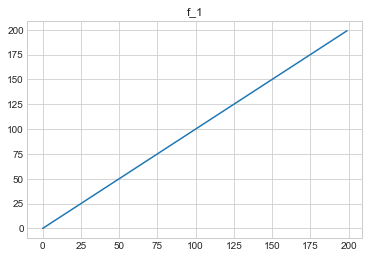

In [5]:
plt.plot(Time,f_1(Time))
plt.title("f_1")
plt.show()

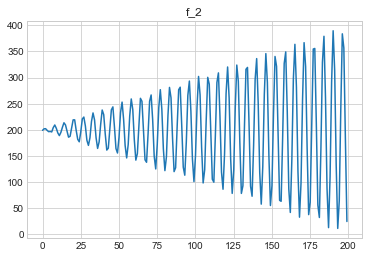

In [6]:
plt.plot(Time,f_2(Time))
plt.title("f_2")
plt.show()

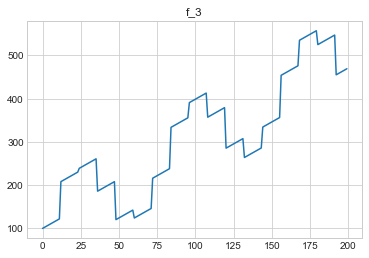

In [7]:
plt.plot(Time,f_3(Time, period=12))
plt.title("f_3")
plt.show()

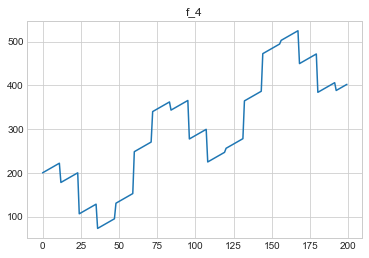

In [8]:
plt.plot(Time,f_4(Time,period=12))
plt.title("f_4")
plt.show()

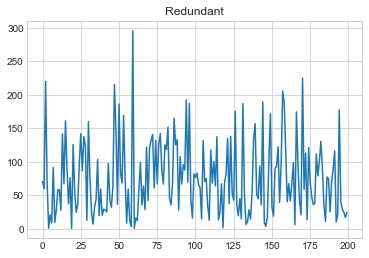

In [9]:
plt.plot(Time,generate_redundant_exog(Time))
plt.title("Redundant")
plt.show()

# Plotting time-series

In [10]:
Exog = np.concatenate([f_1(Time),f_2(Time),f_3(Time, period=12),f_4(Time, period=12)], axis = 1)

In [11]:
Exog.shape

(200, 4)

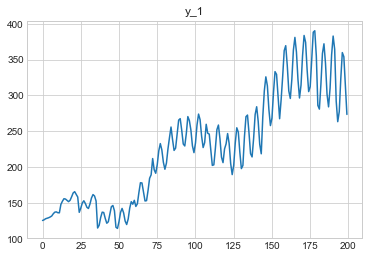

In [12]:
y_1 = generate_ts_1(Exog)

plt.plot(Time,y_1)
plt.title("y_1")
plt.show()

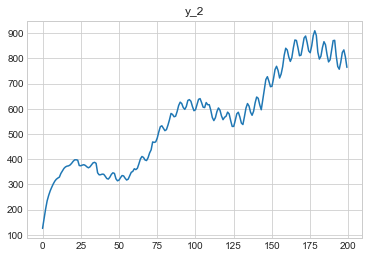

In [13]:
y_2 = generate_ts_2(Exog)

plt.plot(Time,y_2)
plt.title("y_2")
plt.show()

# Addind redundant feature

In [14]:
np.random.seed(123)
Exog = np.concatenate([Exog, generate_redundant_exog(Time)], axis = 1)
Exog.shape

(200, 5)

# Prophet Approach

In [15]:
data_1 = pd.DataFrame(y_1)
data_1.columns = ["y"]
data_1["ds"] = pd.date_range(start='1/1/2018', periods=len(data_1), freq='M')

data_2 = pd.DataFrame({"y": y_2})
data_2["ds"] = pd.date_range(start='1/1/2018', periods=len(data_2), freq='M')

exog = pd.DataFrame(Exog)
exog.columns = ["f1", "f2", "f3", "f4", "redundant"]
exog["ds"] = pd.date_range(start='1/1/2018', periods=len(exog), freq='M')

print(data_1.shape, data_2.shape, exog.shape)

(200, 2) (200, 2) (200, 6)


In [16]:
data_1.head()

,y,ds
0,125.383523,2018-01-31
1,126.327889,2018-02-28
2,127.831906,2018-03-31
3,128.528549,2018-04-30
4,129.241032,2018-05-31


In [17]:
data_2.shape

(200, 2)

In [18]:
exog.head()

,f1,f2,f3,f4,redundant,ds
0,0.0,201.534090,100.0,200.0,108.563060,2018-01-31
1,1.0,200.311557,102.0,202.0,99.734545,2018-02-28
2,2.0,201.327623,104.0,204.0,28.297850,2018-03-31
3,3.0,199.114195,106.0,206.0,150.629471,2018-04-30
4,4.0,196.964130,108.0,208.0,57.860025,2018-05-31


In [19]:
N = 100

data_train_1 = data_1.iloc[:N]
data_test_1 = data_1.iloc[N:]

data_train_2 = data_2.iloc[:N]
data_test_2 = data_2.iloc[N:]

exog_train = exog.iloc[:N]
exog_test = exog.iloc[N:]

In [20]:
y_test_1 = data_test_1["y"].values
del data_test_1["y"]

y_test_2 = data_test_2["y"].values
del data_test_2["y"]

# 1 Experiment: 1-st dataset without exog

In [21]:
# Python
#model = Prophet()

#model.add_seasonality(
#    name='montly', period=7, fourier_order=3, prior_scale=0.1)

#model.fit(data_train_1)

In [22]:
#forecast = model.predict(data_test_1)
#forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [23]:
#mape = np.round(mean_absolute_percentage_error(forecast["yhat"], y_test_1), 3)

#mae = np.round(mean_absolute_error(forecast["yhat"], y_test_1), 3)

#print("MAPE: ", mape, '\n', 
#      "MAE: ", mae)

In [24]:
# forecast_test = model.predict(data_test_1)
# forecast_train = model.predict(data_train_1)

# plt.figure(figsize=(10,7))

# plt.plot(Time, y_1, label = "true")
# plt.plot(Time, np.concatenate([forecast_train["yhat"].values, forecast_test["yhat"].values]), 
#          label = "predictions, \n MAPE = {0}, MAE = {1}".format(mape, mae))


# plt.axvline(x=100, label = "train-test-split", color = 'r')

# plt.xlabel("time", size = 20)
# plt.ylabel("value", size = 20)
# plt.title(" Prophet, 1-st dataset without exog features", size = 20)



# plt.legend(fontsize = 15)

# plt.show()

# 2 Experiment: 2-nd dataset without exog

In [25]:
# # Python
# model = Prophet(n_changepoints=100, changepoint_range=1)
# model.fit(data_train_2)

In [26]:
# forecast = model.predict(data_test_2)
# forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [27]:
# mape = np.round(mean_absolute_percentage_error(forecast["yhat"], y_test_2), 3)

# mae = np.round(mean_absolute_error(forecast["yhat"], y_test_2), 3)

# print("MAPE: ", mape, '\n', 
#       "MAE: ", mae)

In [28]:
# forecast_test = model.predict(data_test_2)
# forecast_train = model.predict(data_train_2)

# plt.figure(figsize=(10,7))

# plt.plot(Time, y_2, label = "true")
# plt.plot(Time, np.concatenate([forecast_train["yhat"].values, forecast_test["yhat"].values]), 
#          label = "predictions, \n MAPE = {0}, MAE = {1}".format(mape, mae))


# plt.axvline(x=100, label = "train-test-split", color = 'r')

# plt.xlabel("time", size = 20)
# plt.ylabel("value", size = 20)
# plt.title(" Prophet, 2-nd dataset without exog features", size = 20)



# plt.legend(fontsize = 15)

# plt.show()

# Merging of features

In [29]:
data_train_1_new = pd.merge(data_train_1, exog_train, on = "ds")

data_test_1_new = pd.merge(data_test_1, exog_test, on = "ds")

print(data_train_1_new.shape, data_test_1_new.shape)
data_train_1_new.head()

(100, 7) (100, 6)


,y,ds,f1,f2,f3,f4,redundant
0,125.383523,2018-01-31,0.0,201.534090,100.0,200.0,108.563060
1,126.327889,2018-02-28,1.0,200.311557,102.0,202.0,99.734545
2,127.831906,2018-03-31,2.0,201.327623,104.0,204.0,28.297850
3,128.528549,2018-04-30,3.0,199.114195,106.0,206.0,150.629471
4,129.241032,2018-05-31,4.0,196.964130,108.0,208.0,57.860025


# 3-rd Experiment: 1-st dataset with exog features

In [30]:
data_train_2_new = pd.merge(data_train_2, exog_train, on = "ds")

data_test_2_new = pd.merge(data_test_2, exog_test, on = "ds")

print(data_train_2_new.shape, data_test_2_new.shape)
data_train_2_new.head()

(100, 7) (100, 6)


,y,ds,f1,f2,f3,f4,redundant
0,125.383523,2018-01-31,0.0,201.534090,100.0,200.0,108.563060
1,163.942946,2018-02-28,1.0,200.311557,102.0,202.0,99.734545
2,202.091494,2018-03-31,2.0,201.327623,104.0,204.0,28.297850
3,234.482938,2018-04-30,3.0,199.114195,106.0,206.0,150.629471
4,256.398507,2018-05-31,4.0,196.964130,108.0,208.0,57.860025


In [31]:
model = Prophet()

model.add_regressor("f1")
model.add_regressor("f2")
model.add_regressor("f3")
model.add_regressor("f4")
model.add_regressor("redundant")

model.fit(data_train_1_new)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [32]:
forecast = model.predict(data_test_1_new)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
95,2034-04-30,323.455822,322.942610,323.996767
96,2034-05-31,359.818687,359.302526,360.363764
97,2034-06-30,354.034550,353.504082,354.591724
98,2034-07-31,312.729100,312.198247,313.279128
99,2034-08-31,273.502293,272.960985,274.074099


In [33]:
mape = np.round(mean_absolute_percentage_error(forecast["yhat"], y_test_1), 3)

mae = np.round(mean_absolute_error(forecast["yhat"], y_test_1), 3)

print("MAPE: ", mape, '\n', 
      "MAE: ", mae)

MAPE:  0.0 
 MAE:  0.043


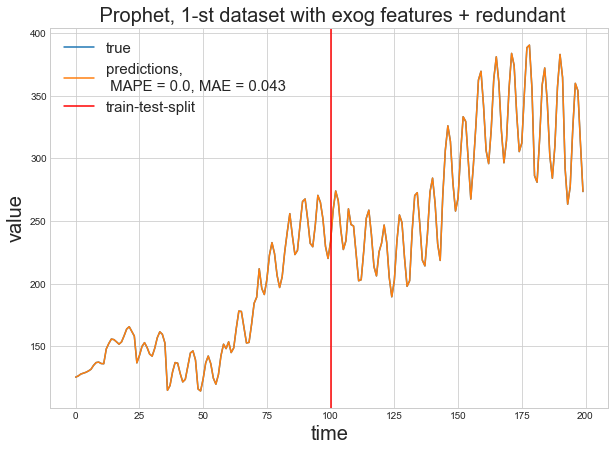

In [34]:
forecast_test = model.predict(data_test_1_new)
forecast_train = model.predict(data_train_1_new)

plt.figure(figsize=(10,7))

plt.plot(Time, y_1, label = "true")
plt.plot(Time, np.concatenate([forecast_train["yhat"].values, forecast_test["yhat"].values]), 
         label = "predictions, \n MAPE = {0}, MAE = {1}".format(mape, mae))


plt.axvline(x=100, label = "train-test-split", color = 'r')

plt.xlabel("time", size = 20)
plt.ylabel("value", size = 20)
plt.title(" Prophet, 1-st dataset with exog features + redundant", size = 20)



plt.legend(fontsize = 15)

plt.show()

# 4-th Experiment: 2-nd dataset with exog features

In [35]:
model = Prophet()

model.add_regressor("f1")
model.add_regressor("f2")
model.add_regressor("f3")
model.add_regressor("f4")
model.add_regressor("redundant")

model.fit(data_train_2_new)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [36]:
forecast = model.predict(data_test_2_new)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
95,2034-04-30,1046.658011,681.042241,1480.791653
96,2034-05-31,1086.896982,717.230716,1530.857710
97,2034-06-30,1088.654183,710.269272,1537.522042
98,2034-07-31,1058.501488,681.130503,1516.355430
99,2034-08-31,1028.286909,642.971936,1489.786290


In [37]:
mape = np.round(mean_absolute_percentage_error(forecast["yhat"], y_test_2), 3)

mae = np.round(mean_absolute_error(forecast["yhat"], y_test_2), 3)

print("MAPE: ", mape, '\n', 
      "MAE: ", mae)

MAPE:  0.163 
 MAE:  143.76


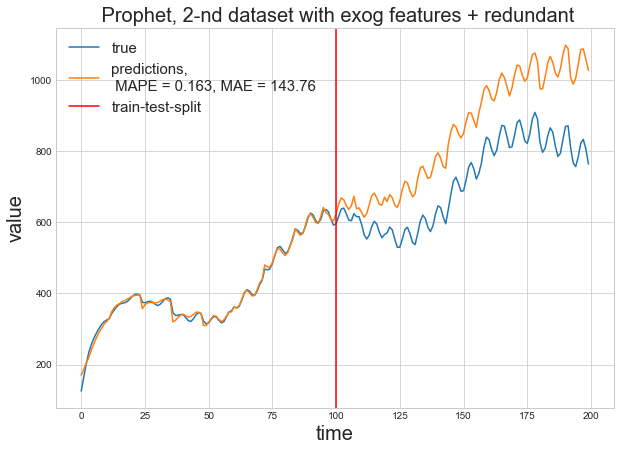

In [38]:
forecast_test = model.predict(data_test_2_new)
forecast_train = model.predict(data_train_2_new)

plt.figure(figsize=(10,7))

plt.plot(Time, y_2, label = "true")
plt.plot(Time, np.concatenate([forecast_train["yhat"].values, forecast_test["yhat"].values]), 
         label = "predictions, \n MAPE = {0}, MAE = {1}".format(mape, mae))


plt.axvline(x=100, label = "train-test-split", color = 'r')

plt.xlabel("time", size = 20)
plt.ylabel("value", size = 20)
plt.title(" Prophet, 2-nd dataset with exog features + redundant", size = 20)



plt.legend(fontsize = 15)

plt.show()

# Model Params:

In [39]:
model.params

{'k': array([[1.19396918]]),
 'm': array([[0.93012182]]),
 'delta': array([[-9.58258561e-08, -4.70345345e-01, -8.38020188e-01,
         -5.92913611e-01, -2.02995605e-01, -1.10147499e-05,
         -3.43213587e-02, -2.55758423e-01, -2.17139401e-02,
         -2.93830789e-04, -9.68876722e-04, -2.86837251e-08,
         -7.52206582e-09,  1.81988008e-09,  2.67148270e-10,
          1.38451282e-06,  7.20678576e-02,  2.23828054e-01,
          2.02234000e-01,  6.76412613e-02,  7.69558754e-03,
          4.98527876e-02,  1.15591011e-05,  1.07124569e-08,
         -5.41941045e-10]]),
 'sigma_obs': array([[0.01359303]]),
 'beta': array([[-2.35909598e-03, -1.55899889e-03, -2.32197367e-02,
         -2.64505543e-02, -2.22172522e-03, -2.60739495e-03,
         -7.41941137e-03, -1.95155395e-03, -7.54155880e-03,
          1.70066602e-03, -1.26922042e-03,  9.09670852e-04,
         -5.59179740e-03, -2.74788316e-04, -6.15968974e-03,
          1.24131108e-03, -8.29788553e-04,  2.35234340e-03,
         -3.3102667